In [25]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## Validating the GTFS stops and CIS data in directions

### Comparing the the frequency of stop sequences of GTFS data in hours 6-25 and CIS data in hours 0-23

There are four heat maps outputted, which indicate the distributions of GTFS data and CIS data of each stop_sequence in hours in different directions.

In [33]:
sql_GTFS_1 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND shape_id = 691042
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df1 = pandasql.read_sql(sql_GTFS_1, con)

df1 = df1.pivot("hours", "stop_sequence", "schedule")

In [34]:
sql_GTFS_0 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040 
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df2 = pandasql.read_sql(sql_GTFS_0, con)

df2 = df2.pivot("hours", "stop_sequence", "schedule")

In [35]:
sql_cis_1 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 1
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691042
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df3 = pandasql.read_sql(sql_cis_1, con)

df3 = df3.pivot("hours", "stop_sequence", "cis_data")

In [36]:
sql_cis_0 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 0
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691040
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df4 = pandasql.read_sql(sql_cis_0, con)

df4 = df4.pivot("hours", "stop_sequence", "cis_data")

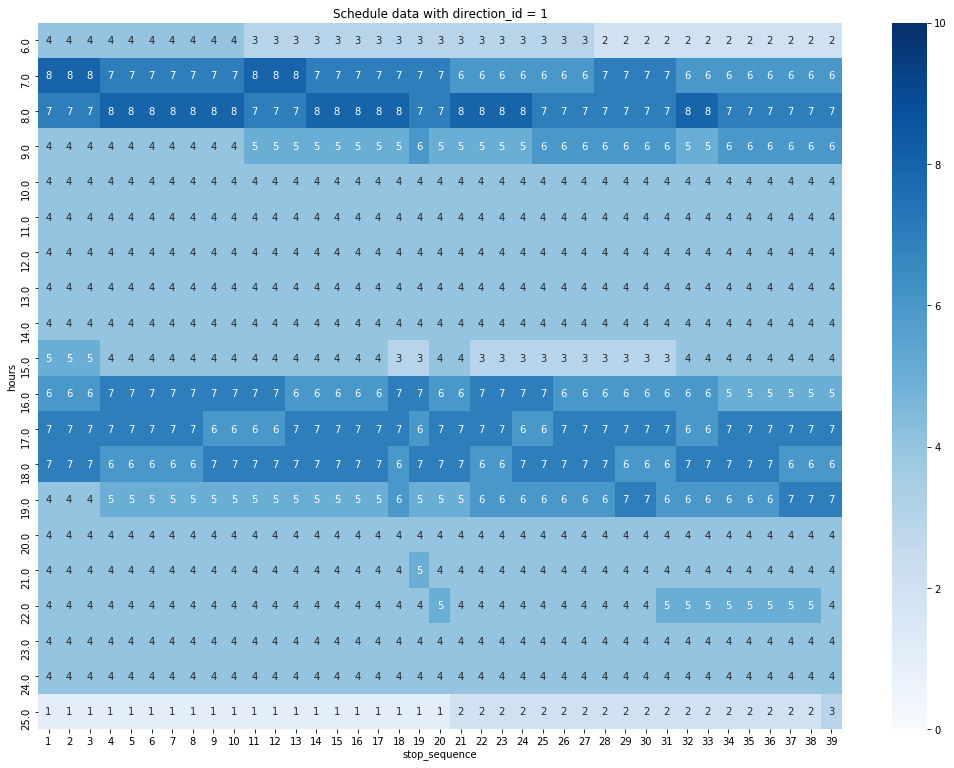

In [42]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('Schedule data with direction_id = 1')
sns.heatmap(df1, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

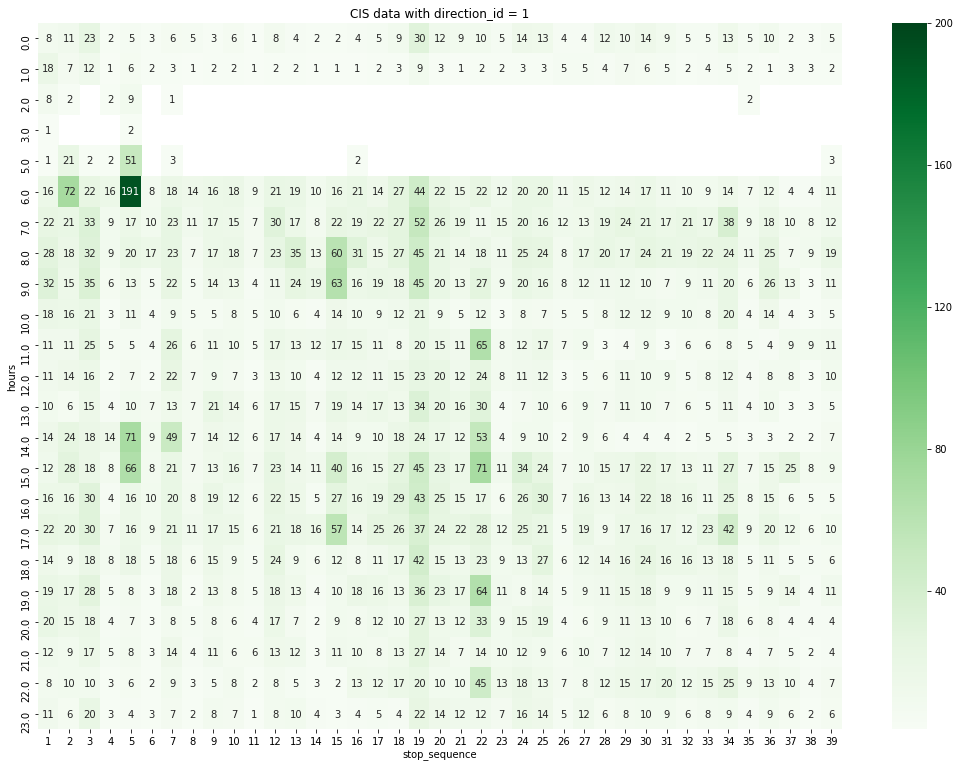

In [43]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS data with direction_id = 1')
sns.heatmap(df3, vmin=1, vmax=200,cmap = 'Greens', annot=True, fmt='g')

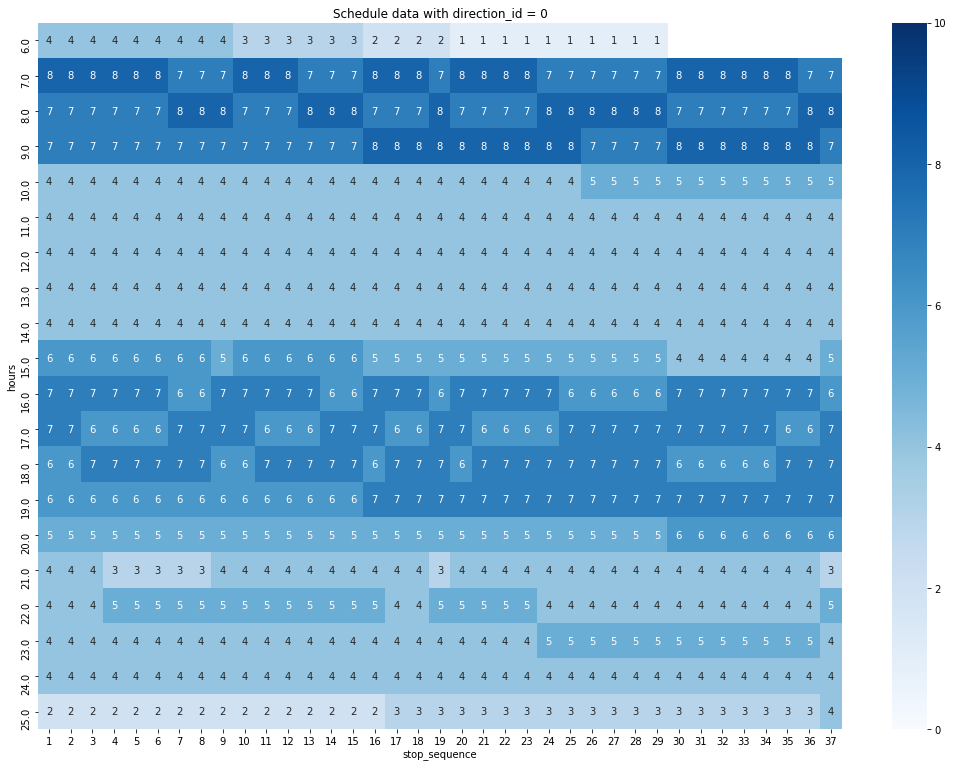

In [44]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('Schedule data with direction_id = 0')
sns.heatmap(df2, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

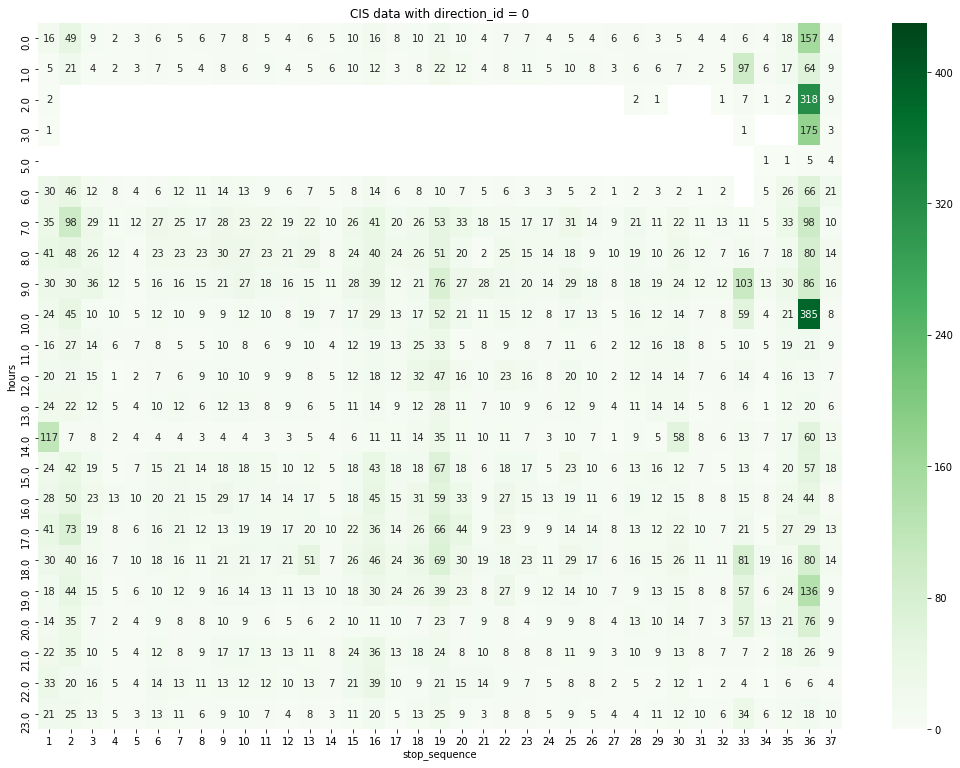

In [41]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS data with direction_id = 0')
sns.heatmap(df4, vmin=0, vmax=430,cmap = 'Greens', annot=True, fmt='g')

### Validating and Comparing the numbers of GTFS data and CIS data in different stop sequences in a day.

#### The heat maps represent the difference between the count of GTFS schedule service and the count of CIS data with the same stop sequence in hours in the direction of 0 and 1.

In [26]:
sql_compare_1 = '''
WITH gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_sequence, count(*) AS GTFS_count
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND shape_id = 691042
GROUP BY hours, stop_sequence
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, sum(array_length(cis_id, 1)) AS cis_count
FROM match_stop
WHERE direction_id = 1
GROUP BY hours, stop_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND shape_id = 691042 
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count
FROM cis_data
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
)

SELECT a.hours, a.stop_sequence, gtfs_count-cis_count AS diff
FROM new_cis_data a, gtfs_data b
WHERE a.hours = b.hours AND a.stop_sequence = b.stop_sequence
ORDER BY a.hours
'''

df5 = pandasql.read_sql(sql_compare_1, con)

df5 = df5.pivot("hours", "stop_sequence", "diff")

In [28]:
sql_compare_0 = '''
WITH gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_sequence, count(*) AS GTFS_count
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040
GROUP BY hours, stop_sequence
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, sum(array_length(cis_id, 1)) AS cis_count
FROM match_stop
WHERE direction_id = 0
GROUP BY hours, stop_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040 
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count
FROM cis_data
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
)

SELECT a.hours, a.stop_sequence, cis_count, gtfs_count, gtfs_count-cis_count AS diff
FROM new_cis_data a, gtfs_data b
WHERE a.hours = b.hours AND a.stop_sequence = b.stop_sequence
ORDER BY a.hours
'''

df6 = pandasql.read_sql(sql_compare_0, con)

df6 = df6.pivot("hours", "stop_sequence", "diff")

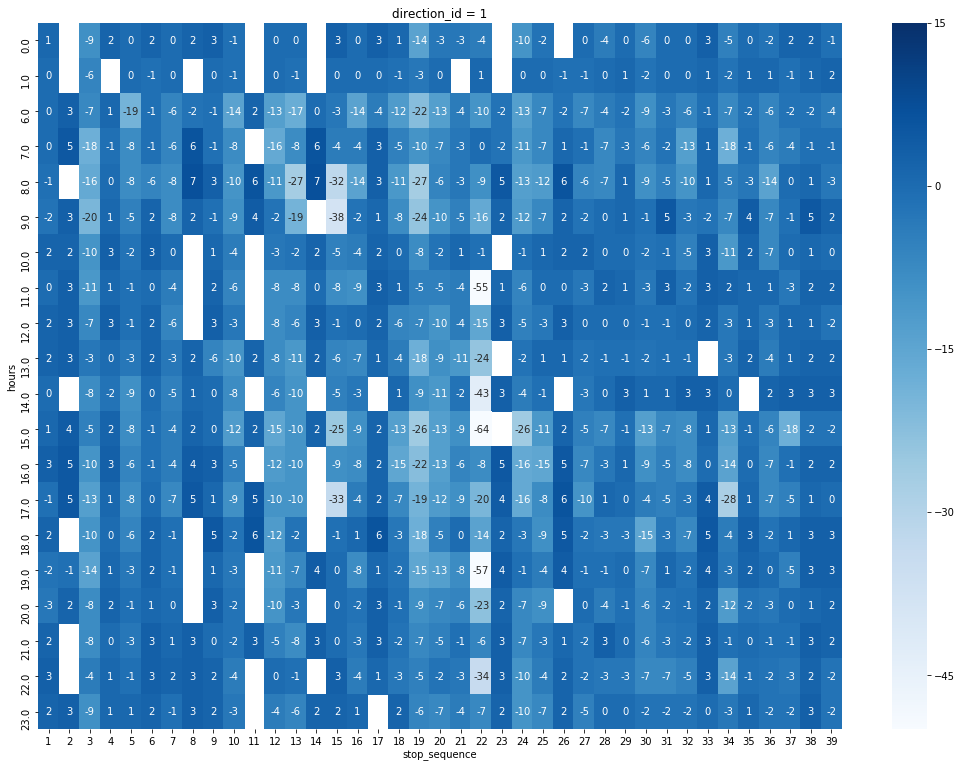

In [32]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('direction_id = 1')
sns.heatmap(df5, vmin=-50, vmax=15, cmap = 'Blues', annot=True, fmt='g')

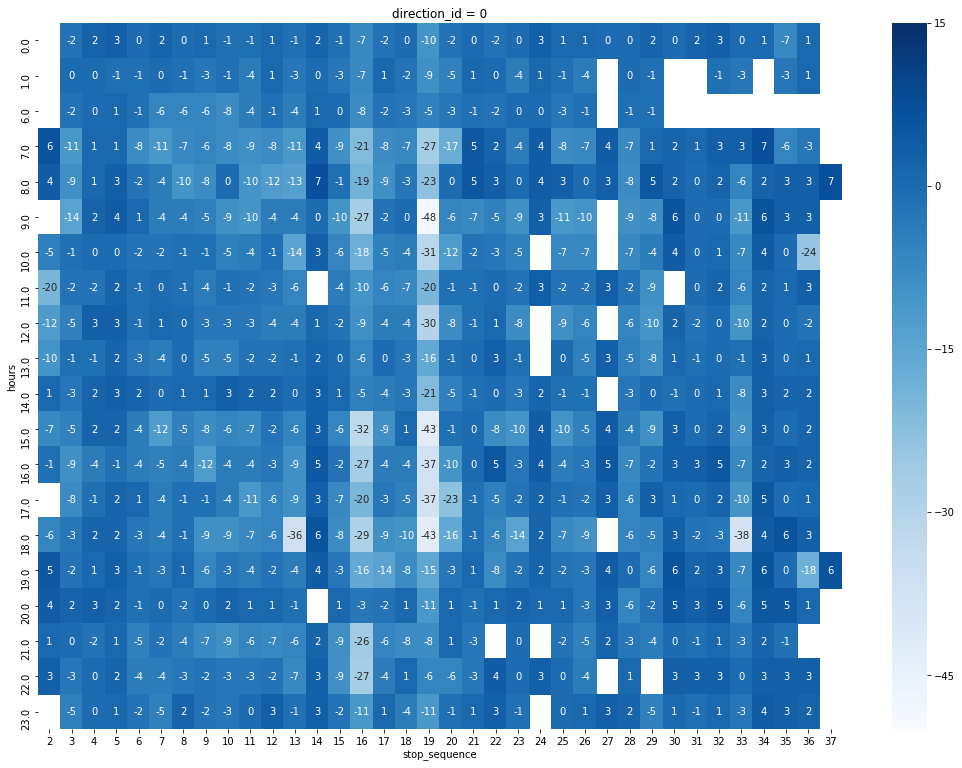

In [31]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('direction_id = 0')
sns.heatmap(df6, vmin=-50, vmax=15, cmap = 'Blues', annot=True, fmt='g')